<a href="https://colab.research.google.com/github/Pheobe-Sun/audio-and-speech-demo/blob/master/Basic_MIR_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basic features for Music Information Retrieval (MIR)
These study notes are adapted from Steve Tjoa's [*MIR tutorial*](https://github.com/slychief/ismir2018_tutorial/blob/master/Part_0_Audio_Basics.ipynb) and Allen Downey's [*ThinkDSP*](https://github.com/AllenDowney/ThinkDSP/blob/master/code/chap01soln.ipynb)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import librosa
from librosa import display
import os
import glob
# import progressbar
from IPython.display import Audio

## Data Exploration

In [2]:
#@markdown Load some sample audio
# !wget https://github.com/Pheobe-Sun/audio-and-speech-demo/blob/master/audio/voice_three.wav
!wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/170255__dublie__trumpet.wav

# import urllib.request
# urllib.request.urlopen('http://audio.musicinformationretrieval.com/c_strum.wav', 'c_strum.wav')
# urllib.request.urlopen('https://github.com/Pheobe-Sun/audio-and-speech-demo/blob/master/audio/voice_three.wav', 'voice_three.wav')

--2021-09-09 18:18:31--  https://github.com/AllenDowney/ThinkDSP/raw/master/code/170255__dublie__trumpet.wav
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/AllenDowney/ThinkDSP/master/code/170255__dublie__trumpet.wav [following]
--2021-09-09 18:18:31--  https://raw.githubusercontent.com/AllenDowney/ThinkDSP/master/code/170255__dublie__trumpet.wav
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1540668 (1.5M) [audio/wav]
Saving to: ‘170255__dublie__trumpet.wav’

170255__dublie__tru 100%[===================>]   1.47M  --.-KB/s    in 0.06s   

2021-09-09 18:18:31 (25.0 MB/s) - ‘170255__dublie__tru

In [3]:
y, sr = librosa.load('170255__dublie__trumpet.wav')
# If run locally, uncomment the following line
# y, sr = librosa.load('audio/voice_three.wav')

print(f'Data dimension: {y.shape}')
print(f'Sampling rate is: {sr}')
print(f'Could you calculate the duration of the audio using the info above?\nCheck your answer: {librosa.get_duration(y, sr):.3}s')
# Play back the loaded audio file
Audio(data=y, rate=sr)

Data dimension: (192562,)
Sampling rate is: 22050
Could you calculate the duration of the audio using the info above?
Check your answer: 8.73s


### Waveform

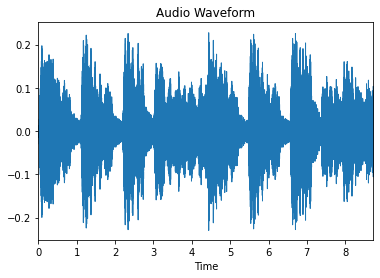

In [4]:
# Visualise the input audio waveform
librosa.display.waveplot(y, sr=sr)
plt.title("Audio Waveform")
plt.show()

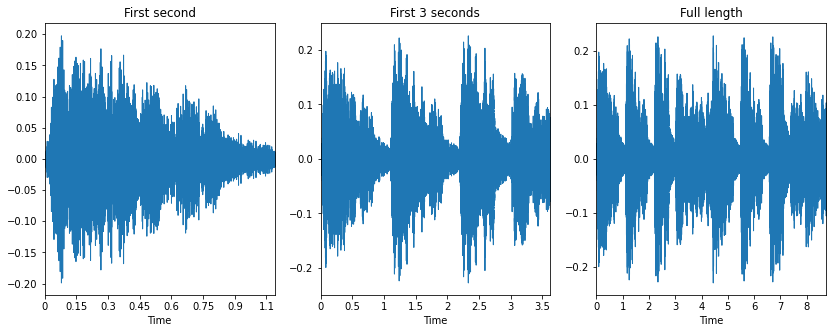

In [5]:
# Showing only the target segment
plt.figure(figsize=(14, 5))
plt.subplot(1, 3, 1)
librosa.display.waveplot(y[:24000], sr=sr) 
plt.title("First second")
plt.subplot(1, 3, 2)
librosa.display.waveplot(y[:80000], sr=sr)
plt.title("First 3 seconds")
plt.subplot(1, 3, 3)
librosa.display.waveplot(y, sr=sr)
plt.title("Full length")
plt.show()

### Spectrogram

In [6]:
spectrogram = librosa.stft(y, n_fft = 1024, hop_length = 512)
print(f"Original data dimension: {y.shape}")
print(f"After stft we get spectrogram with dimension: {spectrogram.shape}")
# print(f"Representation of each row of the spectrogram:\n{spectrogram[512,:]}")

Original data dimension: (192562,)
After stft we get spectrogram with dimension: (513, 377)


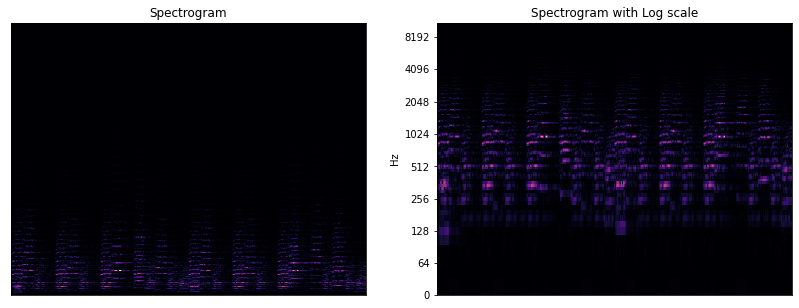

In [7]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
librosa.display.specshow(np.abs(spectrogram), sr=sr)
plt.title("Spectrogram")
plt.subplot(1, 2, 2)
librosa.display.specshow(np.abs(spectrogram), y_axis='log', sr=sr)
plt.title("Spectrogram with Log scale")
plt.show()

### Mel-spectrogram

In [8]:
melspec = librosa.feature.melspectrogram(S=np.abs(spectrogram)**2, n_mels=80, fmax=8000)
melspec_db = librosa.power_to_db(melspec, ref = np.max)
print(f"spectrogram dimension: {spectrogram.shape}")
print(f"Mel spectrogram dimension: {melspec.shape}")
print(f"Mel spectrogram db dimension: {melspec_db.shape}")
# print(f"Representation of each row of the spectrogram: {melspec[0,:]}")
# print(f"Representation of each row of the mel_spectrogram_db: {melspec[0,:]}")

spectrogram dimension: (513, 377)
Mel spectrogram dimension: (80, 377)
Mel spectrogram db dimension: (80, 377)


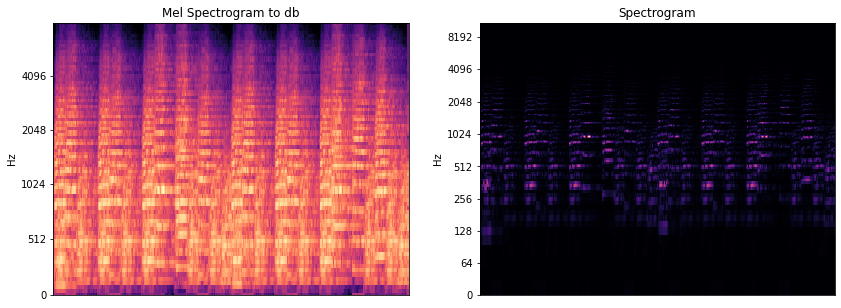

In [9]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
librosa.display.specshow(melspec_db, y_axis='mel', fmax=8000)
plt.title("Mel Spectrogram to db")
plt.subplot(1, 2, 2)
librosa.display.specshow(np.abs(spectrogram), y_axis='log', sr=sr)
plt.title("Spectrogram")
plt.show()

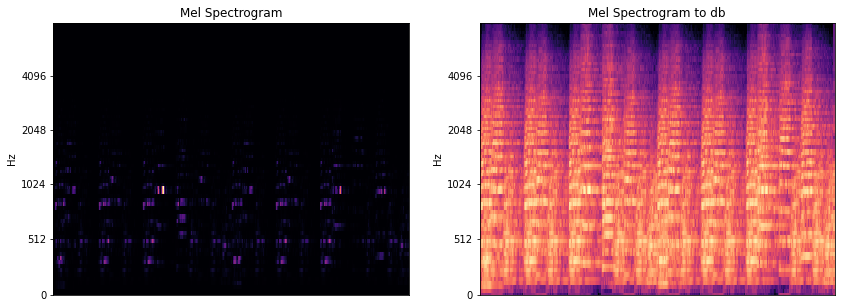

In [10]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
librosa.display.specshow(melspec, y_axis='mel', fmax=8000)
plt.title("Mel Spectrogram")
plt.subplot(1, 2, 2)
librosa.display.specshow(melspec_db, y_axis='mel', fmax=8000)
plt.title("Mel Spectrogram to db")
plt.show()

# Features

## Root-mean-square energy (RMSE)

\begin{align}
\sqrt{\frac{1}{N} \sum_{n} \left\lvert{x(n)}\right\lvert^2}
\end{align}

In [11]:
hop_length = 256
frame_length = 512

energy = np.array([
    sum(abs(y[i: i+frame_length]**2))
    for i in range(0, len(y), hop_length)
])

print(f'Raw data dimension: {y.shape}')
print(f'Energy dimension: {energy.shape}')
print(f'Energy: {energy[:5]}')

Raw data dimension: (192562,)
Energy dimension: (753,)
Energy: [0.05222994 0.19000055 0.54717331 0.96485838 1.30883558]


In [12]:
# note that we are using feature.rms() instead of feature.rmse() as the later is deprecated by Librosa
rmse = librosa.feature.rms(y, frame_length = frame_length, hop_length = hop_length, center = True)
print(f'Raw data dimension: {y.shape}')
print(f'Energy dimension: {energy.shape}')
print(f'Energy: {energy[:5]}')
print(f'RMSE dimension: {rmse.shape}')
print(f'RMSE: {rmse[0,:5]}')

Raw data dimension: (192562,)
Energy dimension: (753,)
Energy: [0.05222994 0.19000055 0.54717331 0.96485838 1.30883558]
RMSE dimension: (1, 753)
RMSE: [0.0068565  0.01010008 0.01926382 0.03269095 0.0434107 ]


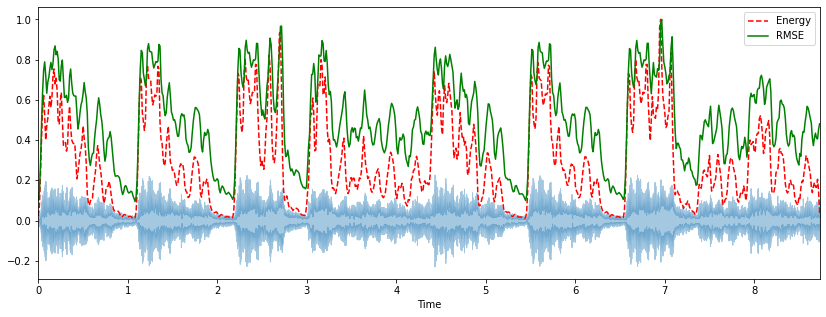

In [13]:
# Get the time points of each frame
frames = range(len(energy))
t = librosa.frames_to_time(frames, sr=sr, hop_length = hop_length)

# Plot the energy and RMSE
plt.figure(figsize=(14, 5))
librosa.display.waveplot(y, sr=sr, alpha=0.4)
plt.plot(t, energy/energy.max(), 'r--')
plt.plot(t[:len(rmse[0])], rmse[0]/rmse[0].max(), color='g')
plt.legend(('Energy', 'RMSE'))
plt.show()

## Zero crossings

Could you count how many zero crossings there are?



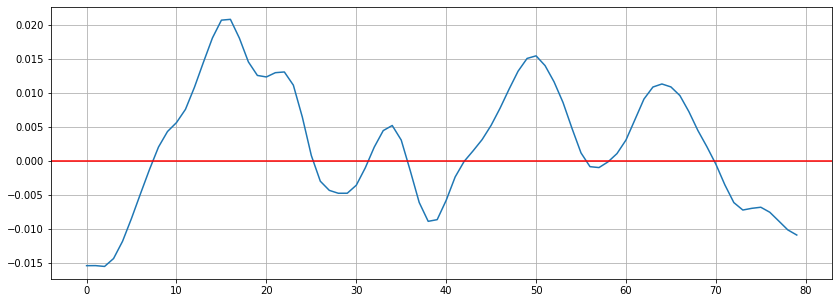

In [14]:
# Select target audio segment
start_frame = 22050
frames = 80

# Plot zero crossings
print(f"Could you count how many zero crossings there are?\n")
plt.figure(figsize=(14, 5))
plt.plot(y[start_frame: start_frame+frames])
plt.grid() # show grid
plt.axhline(0, color='r') # draw a reference line
plt.show()

In [15]:
zero_crossings = librosa.zero_crossings(y[start_frame: start_frame + frames])
print(f"Total frames checked: {zero_crossings.shape}")
print(f"Zero crossings output: {zero_crossings[:10]}")
print(f"The zero crossings are: {np.where(zero_crossings == True)}")
print(f"Total number of zero crossings: {sum(zero_crossings)} - 1") # exclude the count of frame 0
print(f"The zero crossings occur at frame: {np.where(zero_crossings == True)[0][1:]}")  # exclude frame 0

Total frames checked: (80,)
Zero crossings output: [ True False False False False False False False  True False]
The zero crossings are: (array([ 0,  8, 26, 32, 36, 43, 56, 59, 70]),)
Total number of zero crossings: 9 - 1
The zero crossings occur at frame: [ 8 26 32 36 43 56 59 70]


### Zero crossing rate

In [16]:
zcrs = librosa.feature.zero_crossing_rate(y)
print(y.shape)
print(zcrs.shape)
print(zcrs[0][:10])

(192562,)
(1, 377)
[0.06201172 0.08398438 0.10498047 0.08789062 0.08642578 0.08007812
 0.07763672 0.07763672 0.07763672 0.08544922]


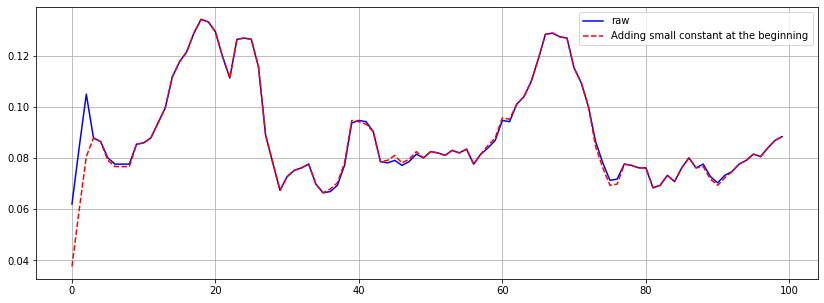

In [17]:
zcrs2 = librosa.feature.zero_crossing_rate(y + 0.0001)

plt.figure(figsize=(14, 5))
plt.plot(zcrs[0][:100], color='b')
plt.plot(zcrs2[0][:100], 'r--')
plt.legend(('raw', 'Adding small constant at the beginning'))
plt.grid()
plt.show()

## Fourier transform

In [18]:
import scipy

In [19]:
y_segmented = y[:7000]
Audio(y_segmented, rate=sr)

(7000,)
[ 1.7979237 -0.j         -0.3123452 -0.15935397j -0.23425357-0.46399248j
  0.04571636-0.43883315j  0.26137078-0.407039j  ]


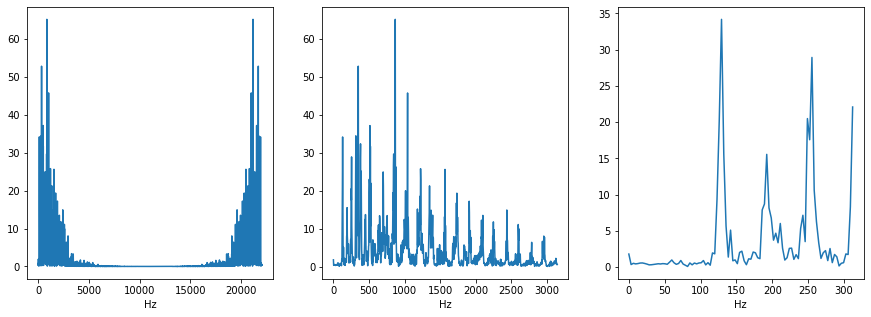

In [20]:
# Perform FFT on the first second of the audio (up to 7000 frame)
X = scipy.fft.fft(y_segmented)
print(X.shape)
print(X[:5])

# Plot fft results
f = np.linspace(0, sr, len(X))

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(f, abs(X)) # magnitude spectrum
plt.xlabel('Hz')
plt.title('')
plt.subplot(1, 3, 2)
plt.plot(f[:1000], abs(X[:1000]))
plt.xlabel('Hz')
plt.title('')
plt.subplot(1, 3, 3)
plt.plot(f[:100], abs(X[:100]))
plt.xlabel('Hz')
plt.title('')
plt.show()

## Short-time fourier transform (STFT)

In [21]:
n_fft = 2048 # window size
hop_length = 512 # frame increment
X_stft = librosa.stft(y, n_fft = n_fft, hop_length = hop_length)
print(y.shape)
print(X_stft.shape)
print(X_stft[0][:5])
print(f"STFT has {X_stft.shape[0]} number of frequency bins and {X_stft.shape[1]} frames")

(192562,)
(1025, 377)
[0.31574976+0.j 0.30159035+0.j 0.3176953 +0.j 0.3329521 +0.j
 0.30440032+0.j]
STFT has 1025 number of frequency bins and 377 frames


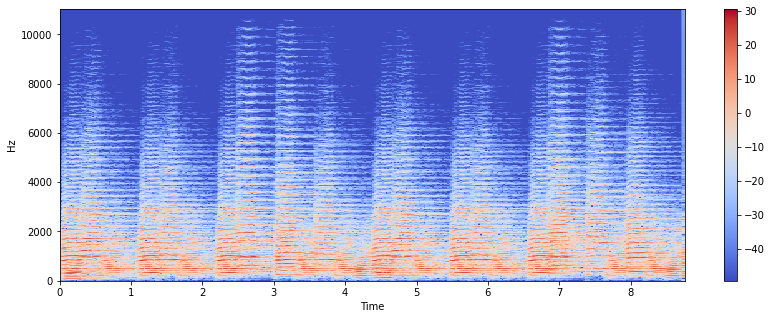

In [22]:
S = librosa.amplitude_to_db(abs(X_stft))

plt.figure(figsize=(14, 5))
librosa.display.specshow(S, sr=sr, hop_length = hop_length, x_axis='time', y_axis='linear')
plt.colorbar()
plt.show()

## Constant-Q Transform

Uses a logarithmically spaced frequency axis

(72, 377)
[ 0.00075646+5.7283237e-06j  0.0001419 -7.4085908e-04j
 -0.00070587-2.7619849e-04j -0.00040987+6.4361736e-04j
  0.00056098+5.2003044e-04j  0.00061536-5.0240051e-04j
 -0.00042933-6.9610984e-04j -0.00072713+3.5037205e-04j
  0.00029508+7.1232516e-04j  0.00067076-2.5104874e-04j]


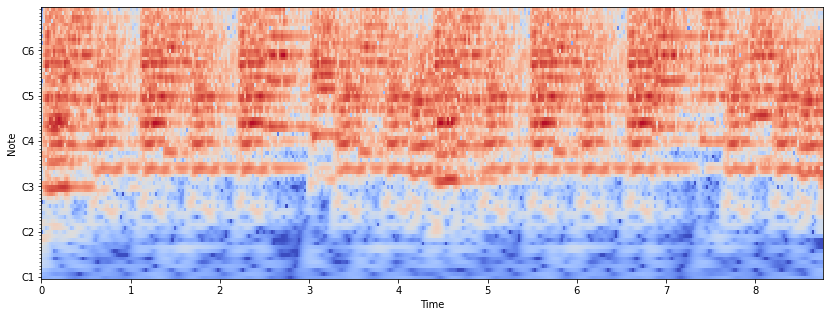

In [23]:
C = librosa.cqt(y, sr=sr, n_bins=72, hop_length=hop_length)
logC = librosa.amplitude_to_db(abs(C))
print(C.shape)
print(C[0][:10])

plt.figure(figsize=(14, 5))
librosa.display.specshow(logC, sr=sr, x_axis="time", y_axis="cqt_note", cmap="coolwarm")
plt.show()

## Chroma

A chroma vector depicts how much energy is present in each of the 12 pitch class 

In [24]:
# chroma
chromagram_stft = librosa.feature.chroma_stft(y, sr=sr, hop_length=hop_length)
chromagram_cqt = librosa.feature.chroma_cqt(y, sr=sr, hop_length=hop_length)
chromagram_cens = librosa.feature.chroma_cens(y, sr=sr, hop_length=hop_length)

print(chromagram_stft.shape)
print(chromagram_cqt.shape)
print(chromagram_cens.shape)

(12, 377)
(12, 377)
(12, 377)


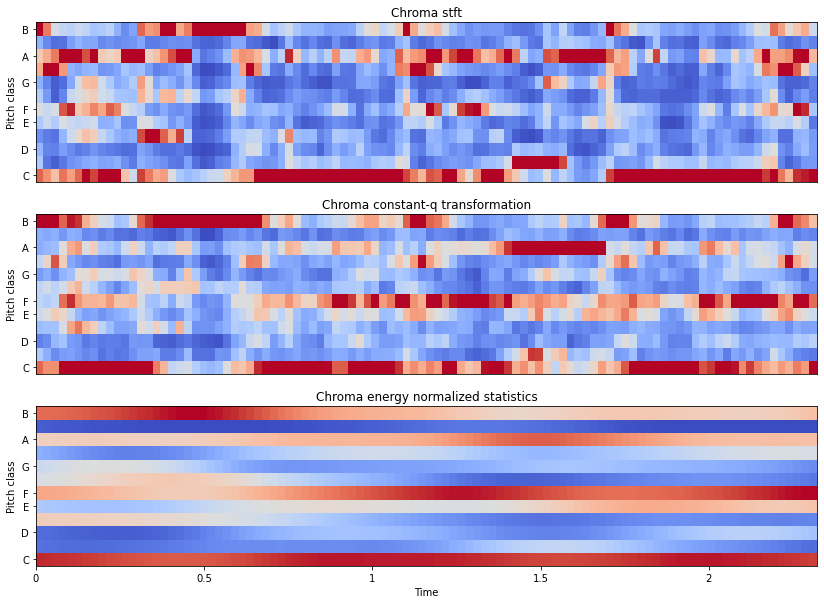

In [25]:
plt.figure(figsize=(14, 10))
plt.subplot(3, 1, 1)
librosa.display.specshow(chromagram_stft[:,:100], y_axis='chroma', hop_length=hop_length, cmap='coolwarm')
plt.title("Chroma stft")
plt.subplot(3, 1, 2)
librosa.display.specshow(chromagram_cqt[:,:100], y_axis='chroma', hop_length=hop_length, cmap='coolwarm')
plt.title("Chroma constant-q transformation")
plt.subplot(3, 1, 3)
librosa.display.specshow(chromagram_cens[:,:100], x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm')
plt.title("Chroma energy normalized statistics")
plt.show()

### Chroma energy normalized statistics (CENS)

*The main idea of CENS features is that taking statistics over large windows smooths local deviations in tempo, articulation, and musical ornaments such as trills and arpeggiated chords. CENS are best used for tasks such as audio matching and similarity.*

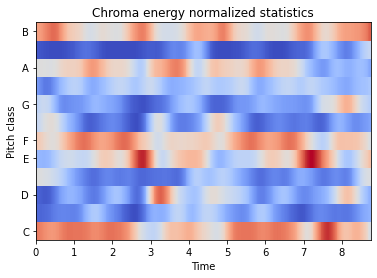

In [26]:
librosa.display.specshow(chromagram_cens, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm')
plt.title("Chroma energy normalized statistics")
plt.show()

## Spectral centroids

The **spectral centroid** indicates at which frequency the energy of a spectrum is centered upon. 

\begin{align}
f_c &= \frac{\sum_k S(k)f(k)}{\sum_k S(k)}
\end{align}

where $S(k)$ is the spectral magnitude at frequency bin $k$, $f(k)$ is the frequency at bin k.

In [27]:
spectral_centroids = librosa.feature.spectral_centroid(y_segmented)[0]
print(spectral_centroids.shape)
print(spectral_centroids[:10])

(14,)
[1056.94325074 1157.81274505 1294.35972934 1330.87606443 1296.4892463
 1253.74512994 1315.26512936 1298.83299231 1300.61744217 1295.83876403]


In [28]:
from sklearn.preprocessing import MinMaxScaler

# define a helper function to normalise the spectral centroid for visualisation
def normalize(x):
  x = np.expand_dims(x, axis=1)
  scaler = MinMaxScaler()
  # x_min = min(x[0])
  # x_max = max(x[0])
  # scaled_x = (x- x_min)/ (x_max - x_min)
  return scaler.fit_transform(x)


print(spectral_centroids[:10])
print(normalize(spectral_centroids).shape)
print(normalize(spectral_centroids)[:10])

[1056.94325074 1157.81274505 1294.35972934 1330.87606443 1296.4892463
 1253.74512994 1315.26512936 1298.83299231 1300.61744217 1295.83876403]
(14, 1)
[[0.        ]
 [0.30645056]
 [0.72129252]
 [0.83223242]
 [0.72776218]
 [0.59790173]
 [0.784805  ]
 [0.73488269]
 [0.74030401]
 [0.72578596]]


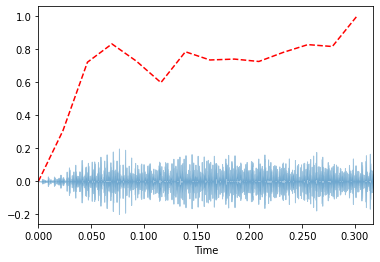

In [29]:
librosa.display.waveplot(y_segmented, sr=sr, alpha=0.4)

frames_sc = range(len(spectral_centroids))
t_sc = librosa.frames_to_time(frames_sc)
plt.plot(t_sc, normalize(spectral_centroids), 'r--')

plt.show()

## Autocorrelation

*The autocorrelation of a signla describes the similarity of a signla against a time-shifted version of itself.* 

\begin{align}
r(k) &= \sum_n x(n) x(n-k)
\end{align}

where $r(k)$ is the autocorrelation of a signal $x$ at different **lag** $k$. $r(k)$ is max when k=0.


Autocorrelation is useful for finding repeated patterns:
- At short lags, the autocorrelation can tell us something about the signal's fundamental frequency
- For longer lags, the autocorrelation may tell us the tempo of music


In [30]:
# Using numpy.correlate
r1 = np.correlate(y_segmented, y_segmented, mode='full')
print(r1.shape)

(13999,)


In [31]:
# Using librosa
r2 = librosa.autocorrelate(y_segmented, max_size=10000)
print(r2.shape)

(7000,)


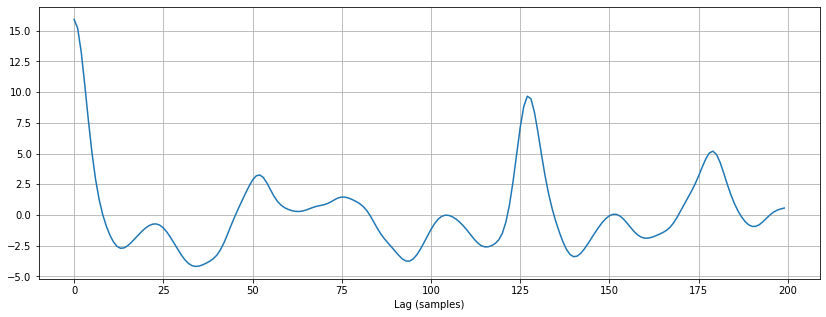

In [32]:
plt.figure(figsize=(14, 5))
plt.plot(r2[:200])
plt.grid()
plt.xlabel('Lag (samples)')
plt.show()

The autocorrelation always has a maximum at zero, i.e., zero lag, as it is the correlation with itself. We are more interested in the maximum outside of the peak centered at zero.

## Mel Frequency Cepstral Coefficients (MFCCs)

The MFCCs of a signal are a small set of features (usually 10-20) which concisely describe the overall shape of a spectral envelope. It is often used to describe **timbre**.

In [37]:
mfcc = librosa.feature.mfcc(y, sr=sr)
print(mfcc.shape)
print(f"{mfcc.shape[0]} MFCCs are calculated over {mfcc.shape[1]} samples")

(20, 377)
20 MFCCs are calculated over 377 samples


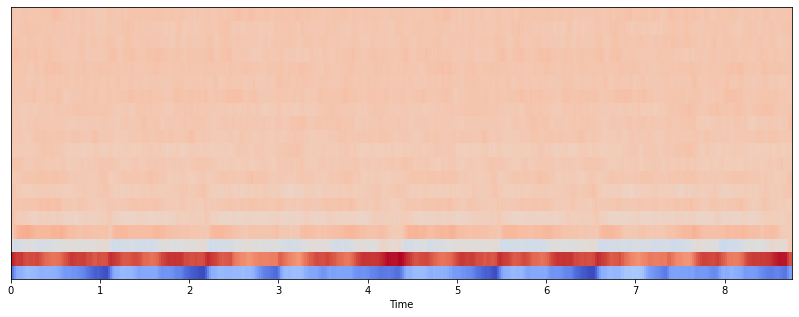

In [39]:
plt.figure(figsize=(14,5))
librosa.display.specshow(mfcc, sr=sr, x_axis='time')
plt.show()

Feature scaling

In [47]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
mfcc_scaled = scaler.fit_transform(mfcc.T).T
print(mfcc.shape)
print(mfcc_scaled.shape)
print(mfcc_scaled.mean(axis=1))
print(mfcc_scaled.std(axis=1))

(20, 377)
(20, 377)
[ 5.0592801e-09 -2.0237120e-08  1.5177841e-08  0.0000000e+00
  1.2648201e-08 -5.0592801e-09 -1.5177841e-08  1.2648201e-08
  1.5177841e-08  1.0118560e-08  5.0592801e-09 -1.5177841e-08
  1.0118560e-08  6.3241004e-09 -1.2648201e-08  2.5296401e-09
 -5.0592801e-09 -1.5177841e-08  0.0000000e+00 -5.0592801e-09]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


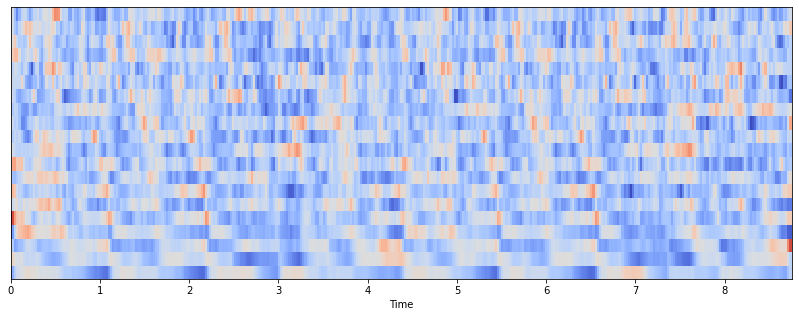

In [46]:
plt.figure(figsize=(14,5))
librosa.display.specshow(mfcc_scaled, sr=sr, x_axis='time')
plt.show()

# Normalisation

In [33]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
data = scaler.fit_transform(melspec_db)
data[0]

array([ 0.5034967 , -0.04870785, -0.47167984, -0.9333486 , -0.8034132 ,
       -0.8295389 , -1.0707577 , -1.15962   , -1.1821206 , -0.9947044 ,
       -1.2571799 , -1.2388885 , -1.1003379 , -0.76121783, -0.64947057,
       -0.6399719 , -0.7951948 , -0.8305112 , -0.9368519 , -0.9126678 ,
       -0.7981397 , -0.73361576, -0.74371314, -0.6511857 , -0.9505358 ,
       -1.3862612 , -1.6304148 , -1.2537768 , -1.7111299 , -1.1078568 ,
       -1.3272431 , -1.1233541 , -1.1135389 , -0.92658836, -0.7733689 ,
       -0.7324109 , -1.4432908 , -1.2466365 , -1.270296  , -1.1188995 ,
       -1.5010614 , -1.1933148 , -1.074256  , -1.33175   , -1.2014875 ,
       -1.0184622 , -1.5606289 , -0.16176377, -0.6781544 , -0.78742594,
       -1.0602691 , -1.0760336 , -1.1239996 , -1.3423215 , -1.4221658 ,
       -1.3666625 , -1.1557505 , -1.1860447 , -1.1704668 , -0.83794606,
       -0.67499566, -0.5105527 , -0.44223702, -0.6310108 , -0.7418624 ,
       -0.7203988 , -0.7170172 , -0.60020864, -0.571614  , -0.57

In [34]:
# check the result of standardisation
print(data.mean())
print(data.std())

0.0
1.0
